In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.decomposition import NMF
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.metrics.cluster import adjusted_rand_score as ARI
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error, precision_recall_curve, jaccard_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.extmath import randomized_svd, squared_norm
import umap
from scipy.sparse.csgraph import connected_components
import networkx as nx
import community
import cvxpy as cp
import cvxopt
import pickle
import math
from math import sqrt
import scipy as sp
from scipy.cluster.hierarchy import linkage,dendrogram
from scipy.special import comb
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix
from scipy.spatial.distance import pdist, jaccard
import h5py

In [15]:
results = pd.DataFrame(index=[], 
                       columns=["name", "m", "n", "noise_mean", "noise_sd", "num", "sim_matrix", "r", "lambdaW", "lambdaH", "lambdaC", "RMSE", "MAE", "AUROC", "AUPRC"])#, "kARI", "kNMI", "lARI", "lNMI"])

## シミュレーション②: simATAC

In [3]:
name = "Buenrostro2018"

In [28]:
# 1 noise 5試行
noise_mean = -1
noise_sd = 1
num = 1

In [30]:
for noise_mean, noise_sd in ([[-1,1],[-2,2],[-3,3]]):
    for num in range(1,6):
        print(noise_mean, noise_sd, num)

-1 1 1
-1 1 2
-1 1 3
-1 1 4
-1 1 5
-2 2 1
-2 2 2
-2 2 3
-2 2 4
-2 2 5
-3 3 1
-3 3 2
-3 3 3
-3 3 4
-3 3 5


In [17]:
for noise_mean, noise_sd in ([[-1,1],[-2,2],[-3,3]]):
    for num in range(1,6):
        count_so_noise_bin_table = pd.read_csv("/home/naoto/scOpen/simATAC/Results/{}/v1.0/count_sim_bin_table_noise_{}_{}_{}.tsv".format(name, noise_mean, noise_sd, num), sep="\t")
        count_so_bin_table = pd.read_csv("/home/naoto/scOpen/simATAC/Results/{}/v1.0/count_sim_bin_table_no_noise_{}_{}_{}.tsv".format(name, noise_mean, noise_sd, num), sep="\t")
        print(count_so_noise_bin_table.shape)
        print(count_so_bin_table.shape)

        count_so_bin_table["i"] = count_so_bin_table["i"] - 1
        count_so_bin_table["j"] = count_so_bin_table["j"] - 1
        count_so_noise_bin_table["i"] = count_so_noise_bin_table["i"] - 1
        count_so_noise_bin_table["j"] = count_so_noise_bin_table["j"] - 1

        M_bin = csr_matrix((count_so_bin_table["x"], (count_so_bin_table["i"], count_so_bin_table["j"]))).toarray()
        X = csr_matrix((count_so_noise_bin_table["x"], (count_so_noise_bin_table["i"], count_so_noise_bin_table["j"]))).toarray()
        print(M_bin.shape)
        print(X.shape)


        with h5py.File("/home/naoto/scOpen/simATAC/Results/{}/v1.0/{}_sim_mat.h5".format(name,name), "r") as f:
            label = f["label"]
            label = pd.DataFrame(label)[0].str.decode("utf-8")

        #LabelEncoderのインスタンスを生成
        le = LabelEncoder()
        #ラベルを覚えさせる
        le = le.fit(label)
        #ラベルを整数に変換
        label_cat = le.transform(label)
        label_cat
        
        
        m = X.shape[0]
        n = X.shape[1]

        rmse_x = mean_squared_error(M_bin, X, squared=False)
        mae_x = mean_absolute_error(M_bin, X)

        fpr_x, tpr_x, thresholds_x = roc_curve(M_bin.flatten(), X.flatten())
        roc_auc_x = auc(fpr_x, tpr_x)

        precision_x, recall_x, thresholds_pr_x = precision_recall_curve(M_bin.flatten(), X.flatten())
        auprc_x= auc(recall_x, precision_x)

        record =  pd.Series([name, m, n, noise_mean, noise_sd, num, "X", 0, 1, 1, 0, rmse_x, mae_x, roc_auc_x, auprc_x], index=results.columns)
        results = results.append(record, ignore_index=True)

        rs = [5,8,10,20,30,40,50,100]
        lambdaCs = [0, 1] #0.1

        for r in rs:
            for lambdaC in lambdaCs:
                WH, W, H, errors = CMF_Impute(X, S_lsi_M, r, 1,1,lambdaC, False)
                WH[WH < 0] = 0

                AA = X.astype(float)
                for i in range(X.shape[0]):
                    for j in range(X.shape[1]):
                        if X[i,j] == 0:
                            AA[i,j] = WH[i,j]

                rmse_aa = mean_squared_error(M_bin, AA, squared=False)
                mae_aa = mean_absolute_error(M_bin, AA)
                print(rmse_aa, mae_aa)

                fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
                roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
                print(roc_auc_nhmf_aa)


                precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
                auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
                print(auprc_nhmf_aa)

                record =  pd.Series([name, m, n, noise_mean, noise_sd, num, "S_lsi_M", r, 1, 1, lambdaC, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
                results = results.append(record, ignore_index=True)

        pd.DataFrame(X).to_csv("hoge.tsv", sep="\t")
        for r in rs:

            !scopen --input hoge.tsv --input-format dense --output-dir ./ --output-prefix hoge_scOpen --output-format dense --n-components {r}          
            WH = pd.read_csv("hoge_scOpen.txt", sep="\t", index_col=0).to_numpy()
            print(WH.shape)

            WH[WH < 0] = 0

            AA = X.astype(float)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    if X[i,j] == 0:
                        AA[i,j] = WH[i,j]

            rmse_aa = mean_squared_error(M_bin, AA, squared=False)
            mae_aa = mean_absolute_error(M_bin, AA)
            print(rmse_aa, mae_aa)

            fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
            roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
            print(roc_auc_nhmf_aa)


            precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
            auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
            print(auprc_nhmf_aa)

            record =  pd.Series([name, m, n, noise_mean, noise_sd, num, "scOpen", r, 1, 1, 0, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
            results = results.append(record, ignore_index=True)

(1859323, 3)
(3875119, 3)
(5000, 1974)
(5000, 1974)
0.3716872415950765 0.23842340943368082
0.8555890934091099
0.8182315817701464
0.37208446024349934 0.23857249342665443
0.8540761947056168
0.8161440911429263
0.3717712794879343 0.23709899619995112
0.8559981180088387
0.8246361644914499
0.37161191659990656 0.2374820406712301
0.855132958482274
0.8215913074816028
0.37195853990535405 0.2365958508599477
0.8557370780554562
0.8199965939779619
0.3712648950742709 0.23682285346546622
0.855964165813557
0.8207266326955971
0.3740803784018349 0.23653162966987165
0.850793121418017
0.8120192796419612
0.3731693548801843 0.23632754506813394
0.8527022501026109
0.8088031783826504
0.3760584493100046 0.23650191038368026
0.8457385168831217
0.7984986271762616
0.37502505491884003 0.2363029381790916
0.8484481997989951
0.805796932763604
0.37790562359778496 0.2365200210286712
0.8408538704775658
0.7908278519219096
0.37675940045091855 0.23630301247798893
0.8441938091379572
0.7981098908810677
0.37958017103480574 0.2365

KeyboardInterrupt: 

In [29]:
results["RMSE"] = np.sqrt(results["RMSE"])

In [31]:
# results.to_csv("Buen.tsv", sep="\t")

In [161]:
results = pd.read_csv("Buen.tsv", sep="\t", index_col=0)
results

,name,m,n,noise_mean,noise_sd,num,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,Buenrostro2018,5000,1974,-1,1,1,X,0,1,1,0,0.663887,0.204235,0.739905,0.842023
1,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,5,1,1,0,0.609662,0.238423,0.855589,0.818232
2,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,5,1,1,1,0.609987,0.238572,0.854076,0.816144
3,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,8,1,1,0,0.609730,0.237099,0.855998,0.824636
4,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,8,1,1,1,0.609600,0.237482,0.855133,0.821591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Buenrostro2018,5000,1974,-2,2,1,S_lsi_M,100,1,1,1,0.620393,0.236561,0.822989,0.769083
142,Buenrostro2018,5000,1974,-2,2,1,scOpen,5,1,1,0,0.606481,0.245015,0.855545,0.846411
143,Buenrostro2018,5000,1974,-2,2,1,scOpen,8,1,1,0,0.606505,0.243617,0.856010,0.846852
144,Buenrostro2018,5000,1974,-2,2,1,scOpen,10,1,1,0,0.606654,0.243481,0.855635,0.846515


In [36]:
results_fix = results
results_fix.loc[results_fix["sim_matrix"] == "X","lambdaC"] = "raw matrix"
results_fix.loc[results_fix["sim_matrix"] == "scOpen","lambdaC"] = "scOpen"
results_fix

,name,m,n,noise_mean,noise_sd,num,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,Buenrostro2018,5000,1974,-1,1,1,X,0,1,1,raw matrix,0.663887,0.204235,0.739905,0.842023
1,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,5,1,1,0,0.609662,0.238423,0.855589,0.818232
2,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,5,1,1,1,0.609987,0.238572,0.854076,0.816144
3,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,8,1,1,0,0.609730,0.237099,0.855998,0.824636
4,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,8,1,1,1,0.609600,0.237482,0.855133,0.821591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Buenrostro2018,5000,1974,-2,2,1,S_lsi_M,100,1,1,1,0.620393,0.236561,0.822989,0.769083
142,Buenrostro2018,5000,1974,-2,2,1,scOpen,5,1,1,scOpen,0.606481,0.245015,0.855545,0.846411
143,Buenrostro2018,5000,1974,-2,2,1,scOpen,8,1,1,scOpen,0.606505,0.243617,0.856010,0.846852
144,Buenrostro2018,5000,1974,-2,2,1,scOpen,10,1,1,scOpen,0.606654,0.243481,0.855635,0.846515


In [47]:
results_fix = results_fix[results_fix["r"]!=100]

In [65]:
results_fix.loc[results_fix["lambdaC"] == 0,"lambdaC"] = "lambdaC = 0"
results_fix.loc[results_fix["lambdaC"] == 1,"lambdaC"] = "lambdaC = 1"

/home/naoto/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [66]:
results_fix

,name,m,n,noise_mean,noise_sd,num,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,Buenrostro2018,5000,1974,-1,1,1,X,0,1,1,raw matrix,0.663887,0.204235,0.739905,0.842023
1,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,5,1,1,lambdaC = 0,0.609662,0.238423,0.855589,0.818232
2,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,5,1,1,lambdaC = 1,0.609987,0.238572,0.854076,0.816144
3,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,8,1,1,lambdaC = 0,0.609730,0.237099,0.855998,0.824636
4,Buenrostro2018,5000,1974,-1,1,1,S_lsi_M,8,1,1,lambdaC = 1,0.609600,0.237482,0.855133,0.821591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Buenrostro2018,5000,1974,-2,2,1,S_lsi_M,50,1,1,lambdaC = 1,0.615129,0.236323,0.840023,0.785085
142,Buenrostro2018,5000,1974,-2,2,1,scOpen,5,1,1,scOpen,0.606481,0.245015,0.855545,0.846411
143,Buenrostro2018,5000,1974,-2,2,1,scOpen,8,1,1,scOpen,0.606505,0.243617,0.856010,0.846852
144,Buenrostro2018,5000,1974,-2,2,1,scOpen,10,1,1,scOpen,0.606654,0.243481,0.855635,0.846515


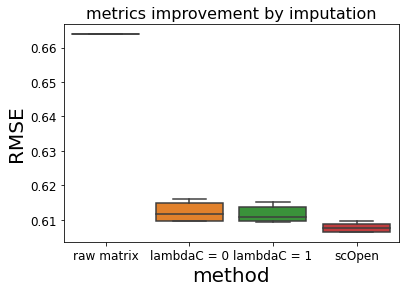

In [82]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='lambdaC', y='RMSE', data=results_fix, ax=ax)

ax.set_xlabel('method', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
# ax.set_ylim(-0.03, 0.1)
# ax.legend()
plt.title("metrics improvement by imputation", fontsize=16)
plt.tick_params(labelsize=12)
# plt.savefig("basic_sim_droprate_improvement.png")
plt.show()


In [68]:
fuga = pd.DataFrame({
    "value": [],
    "method": [],
    "label": []
})
for label in ["AUROC", "AUPRC", "RMSE", "MAE"]:
    df = results_fix.loc[:,[label, "lambdaC"]]
    df.columns = ["value", "method"]    
    df["label"] = label
    fuga = pd.concat([fuga, df])

fuga

,value,method,label
0,0.739905,raw matrix,AUROC
1,0.855589,lambdaC = 0,AUROC
2,0.854076,lambdaC = 1,AUROC
3,0.855998,lambdaC = 0,AUROC
4,0.855133,lambdaC = 1,AUROC
...,...,...,...
139,0.236323,lambdaC = 1,MAE
142,0.245015,scOpen,MAE
143,0.243617,scOpen,MAE
144,0.243481,scOpen,MAE


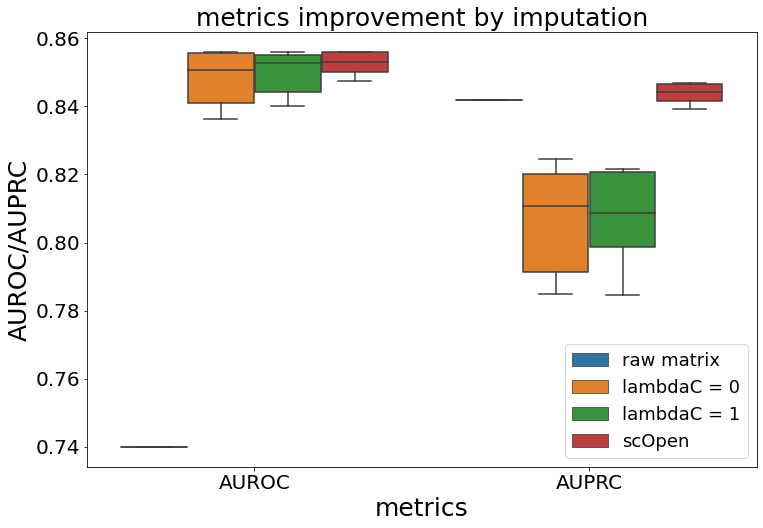

In [69]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='label', y='value', data=fuga[fuga["label"].isin(["AUROC", "AUPRC"])], hue='method', ax=ax)

ax.set_xlabel('metrics', fontsize=25)
ax.set_ylabel('AUROC/AUPRC', fontsize=25)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("metrics improvement by imputation", fontsize=25)
# plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


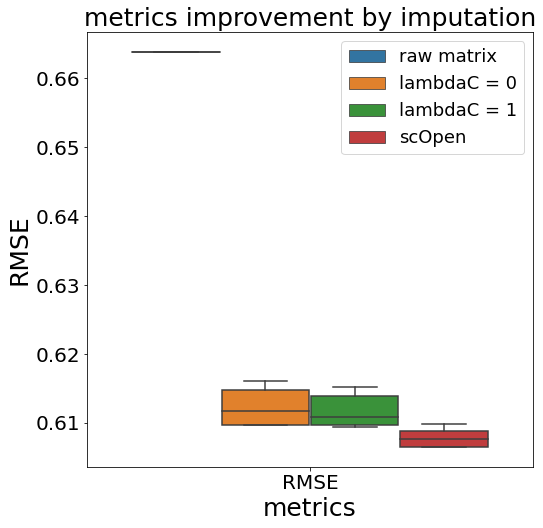

In [70]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='label', y='value', data=fuga[fuga["label"].isin(["RMSE"])], hue='method', ax=ax) # , palette='Dark2'

ax.set_xlabel('metrics', fontsize=25)
ax.set_ylabel('RMSE', fontsize=25)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("metrics improvement by imputation", fontsize=25)
# plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


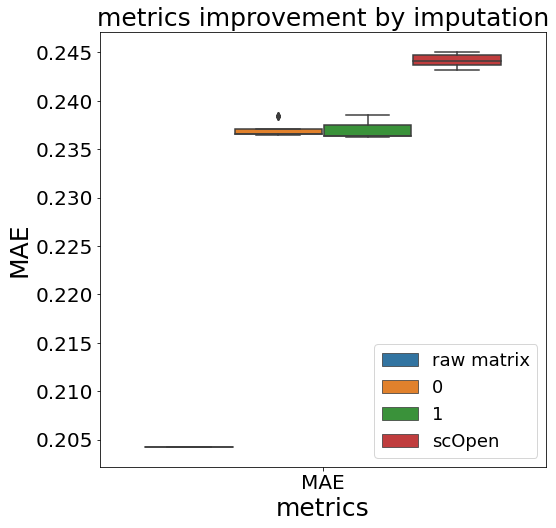

In [61]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='label', y='value', data=fuga[fuga["label"].isin(["MAE"])], hue='method', ax=ax)

ax.set_xlabel('metrics', fontsize=25)
ax.set_ylabel('MAE', fontsize=25)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("metrics improvement by imputation", fontsize=25)
# plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


In [127]:
clus_res = pd.DataFrame(index=[], columns=["r", "lambdaC", "n_comp", "n_cluster", "n_nns", "kARI_WH", "kARI_WH_S", "kARI_raw", "kARI_1-raw", "kARI_1-so", "kNMI_WH", "kNMI_WH_S", "kNMI_raw", "kNMI_1-raw", "kNMI_1-so", "lARI_WH", "lARI_WH_S", "lARI_raw", "lARI_1-raw", "lARI_1-so", "lNMI_WH", "lNMI_WH_S", "lNMI_raw", "lNMI_1-raw", "lNMI_1-so"])

In [151]:
WH, W, H, errors = CMF_Impute(X, S_lsi_M, 30, 1,1,1, False)
# WH[WH < 0] = 0
# AA = X.astype(float)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         if X[i,j] == 0:
#             AA[i,j] = WH[i,j]

In [152]:
pd.DataFrame(X).to_csv("hoge.tsv", sep="\t")
!scopen --input hoge.tsv --input-format dense --output-dir ./ --output-prefix hoge_scOpen --output-format dense --n-components 30          
# WH = pd.read_csv("hoge_scOpen.txt", sep="\t", index_col=0).to_numpy()
# WH[WH < 0] = 0
# AA_S = X.astype(float)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         if X[i,j] == 0:
#             AA_S[i,j] = WH[i,j]

Number of peaks: 5000; number of cells 1974
Sparsity before imputation: 0.8116187436676798
Sparsity after imputation: 4.457953394099157e-06
[total time:  0h 0m 12s ]


In [133]:
# # pca向き
n_components = 50
n_cluster = 8
n_nns = 50
pca = PCA(n_components=n_components)
pca_X = pca.fit(X)
# pca_WH = pca.fit(WH)
pca_WH = pca.fit(AA)
pca_WH_S = pca.fit(AA_S)
print(pca_X.components_.T.shape)

# PCAじゃなくてLSIでやりたいところ

# initialization dependency

for _i in range(9):

    # kmeans = KMeans(n_clusters=n_cluster).fit(pca_X.components_.T)
    kmeans = KMedoids(n_clusters=n_cluster, init="k-medoids++").fit(pca_X.components_.T)
    X_label_k = kmeans.labels_
    # kmeans = KMeans(n_clusters=n_cluster).fit(pca_WH.components_.T)
    kmeans = KMedoids(n_clusters=n_cluster, init="k-medoids++").fit(pca_WH.components_.T)
    WH_label_k = kmeans.labels_
    # kmeans = KMeans(n_clusters=n_cluster).fit(pca_WH_S.components_.T)
    kmeans = KMedoids(n_clusters=n_cluster, init="k-medoids++").fit(pca_WH_S.components_.T)
    WH_S_label_k = kmeans.labels_

    kARI_WH = ARI(label_cat, WH_label_k)
    kARI_WH_S = ARI(label_cat, WH_S_label_k)
    kARI_raw = ARI(label_cat, X_label_k)

    kNMI_WH = NMI(label_cat, WH_label_k)
    kNMI_WH_S = NMI(label_cat, WH_S_label_k)
    kNMI_raw = NMI(label_cat, X_label_k)

    # Louvain clustering
    A = kneighbors_graph(pca_WH.components_.T, n_nns)
    G = nx.convert_matrix.from_numpy_array(A.toarray())
    WH_label_l = list(community.best_partition(G).values())

    A = kneighbors_graph(pca_WH_S.components_.T, n_nns)
    G = nx.convert_matrix.from_numpy_array(A.toarray())
    WH_S_label_l = list(community.best_partition(G).values())

    A = kneighbors_graph(pca_X.components_.T, n_nns)
    G = nx.convert_matrix.from_numpy_array(A.toarray())
    X_label_l = list(community.best_partition(G).values())


    lARI_WH = ARI(label_cat, WH_label_l)
    lARI_WH_S = ARI(label_cat, WH_S_label_l)
    lARI_raw = ARI(label_cat, X_label_l)

    lNMI_WH = NMI(label_cat, WH_label_l)
    lNMI_WH_S = NMI(label_cat, WH_S_label_l)
    lNMI_raw = NMI(label_cat, X_label_l)
    
    record =  pd.Series([8, 1, n_components, n_cluster, n_nns, kARI_WH, kARI_WH_S, kARI_raw, kARI_WH-kARI_raw, kARI_WH-kARI_WH_S, kNMI_WH, kNMI_WH_S, kNMI_raw, kNMI_WH-kNMI_raw, kNMI_WH-kNMI_WH_S, lARI_WH, lARI_WH_S, lARI_raw, lARI_WH-lARI_raw,lARI_WH-lARI_WH_S, lNMI_WH, lNMI_WH_S, lNMI_raw, lNMI_WH-lNMI_raw, lNMI_WH-lNMI_WH_S], index=clus_res.columns)
    clus_res = clus_res.append(record, ignore_index=True)

(1974, 50)


In [159]:
clus_res

,Unnamed: 0,r,lambdaC,n_comp,n_cluster,n_nns,kARI_WH,kARI_WH_S,kARI_raw,kARI_1-raw,...,lARI_WH,lARI_WH_S,lARI_raw,lARI_1-raw,lARI_1-so,lNMI_WH,lNMI_WH_S,lNMI_raw,lNMI_1-raw,lNMI_1-so
0,0,8.0,1.0,50.0,8.0,50.0,0.021801,-0.001578,0.024705,-0.002905,...,0.290895,0.149600,0.245837,0.045057,0.141295,0.491319,0.332298,0.468289,0.023030,0.159021
1,1,8.0,1.0,50.0,8.0,50.0,0.034922,0.041851,0.006405,0.028517,...,0.326151,0.194782,0.194759,0.131391,0.131369,0.500877,0.411009,0.406106,0.094771,0.089868
2,2,8.0,1.0,50.0,8.0,50.0,-0.000801,0.046462,0.022034,-0.022834,...,0.345069,0.201962,0.171335,0.173734,0.143107,0.513259,0.408805,0.383348,0.129910,0.104454
3,3,8.0,1.0,50.0,8.0,50.0,0.013533,0.022107,0.013815,-0.000282,...,0.202585,0.236486,0.210326,-0.007741,-0.033900,0.408716,0.456962,0.420601,-0.011885,-0.048246
4,4,8.0,1.0,50.0,8.0,50.0,-0.017087,0.011068,0.044993,-0.062081,...,0.336319,0.348535,0.240764,0.095555,-0.012216,0.524001,0.526838,0.454380,0.069621,-0.002837
5,5,8.0,1.0,50.0,8.0,50.0,0.037069,0.021425,0.009230,0.027839,...,0.200935,0.234553,0.210187,-0.009251,-0.033618,0.410824,0.450098,0.427694,-0.016870,-0.039274
6,6,8.0,1.0,50.0,8.0,50.0,0.030755,0.018460,-0.002549,0.033304,...,0.221980,0.148166,0.243071,-0.021091,0.073814,0.428556,0.335911,0.453813,-0.025257,0.092645
7,7,8.0,1.0,50.0,8.0,50.0,0.034713,0.020690,0.013387,0.021325,...,0.210384,0.279363,0.223165,-0.012781,-0.068979,0.414528,0.478566,0.435397,-0.020869,-0.064038
8,8,8.0,1.0,50.0,8.0,50.0,0.029290,0.034921,0.016192,0.013098,...,0.243314,0.208950,0.209735,0.033579,0.034364,0.442120,0.401404,0.434915,0.007204,0.040716
9,9,8.0,1.0,50.0,8.0,50.0,0.032894,0.034048,0.015333,0.017561,...,0.212338,0.235459,0.285496,-0.073158,-0.023121,0.434290,0.447019,0.465089,-0.030799,-0.012729


In [156]:
clus_res.to_csv("Buen_clustering.tsv", sep="\t")

In [160]:
clus_res = pd.read_csv("Buen_clustering.tsv", sep="\t", index_col=0)

In [135]:
fuga = clus_res[(clus_res["n_comp"]==50) & (clus_res["n_nns"]==50)]
fuga

,r,lambdaC,n_comp,n_cluster,n_nns,kARI_WH,kARI_WH_S,kARI_raw,kARI_1-raw,kARI_1-so,...,lARI_WH,lARI_WH_S,lARI_raw,lARI_1-raw,lARI_1-so,lNMI_WH,lNMI_WH_S,lNMI_raw,lNMI_1-raw,lNMI_1-so
0,8.0,1.0,50.0,8.0,50.0,0.021801,-0.001578,0.024705,-0.002905,0.023379,...,0.290895,0.149600,0.245837,0.045057,0.141295,0.491319,0.332298,0.468289,0.023030,0.159021
1,8.0,1.0,50.0,8.0,50.0,0.034922,0.041851,0.006405,0.028517,-0.006930,...,0.326151,0.194782,0.194759,0.131391,0.131369,0.500877,0.411009,0.406106,0.094771,0.089868
2,8.0,1.0,50.0,8.0,50.0,-0.000801,0.046462,0.022034,-0.022834,-0.047262,...,0.345069,0.201962,0.171335,0.173734,0.143107,0.513259,0.408805,0.383348,0.129910,0.104454
3,8.0,1.0,50.0,8.0,50.0,0.013533,0.022107,0.013815,-0.000282,-0.008573,...,0.202585,0.236486,0.210326,-0.007741,-0.033900,0.408716,0.456962,0.420601,-0.011885,-0.048246
4,8.0,1.0,50.0,8.0,50.0,-0.017087,0.011068,0.044993,-0.062081,-0.028156,...,0.336319,0.348535,0.240764,0.095555,-0.012216,0.524001,0.526838,0.454380,0.069621,-0.002837
5,8.0,1.0,50.0,8.0,50.0,0.037069,0.021425,0.009230,0.027839,0.015644,...,0.200935,0.234553,0.210187,-0.009251,-0.033618,0.410824,0.450098,0.427694,-0.016870,-0.039274
6,8.0,1.0,50.0,8.0,50.0,0.030755,0.018460,-0.002549,0.033304,0.012295,...,0.221980,0.148166,0.243071,-0.021091,0.073814,0.428556,0.335911,0.453813,-0.025257,0.092645
7,8.0,1.0,50.0,8.0,50.0,0.034713,0.020690,0.013387,0.021325,0.014022,...,0.210384,0.279363,0.223165,-0.012781,-0.068979,0.414528,0.478566,0.435397,-0.020869,-0.064038
8,8.0,1.0,50.0,8.0,50.0,0.029290,0.034921,0.016192,0.013098,-0.005632,...,0.243314,0.208950,0.209735,0.033579,0.034364,0.442120,0.401404,0.434915,0.007204,0.040716
9,8.0,1.0,50.0,8.0,50.0,0.032894,0.034048,0.015333,0.017561,-0.001154,...,0.212338,0.235459,0.285496,-0.073158,-0.023121,0.434290,0.447019,0.465089,-0.030799,-0.012729


In [138]:
# fuga = fuga[["kARI_1-raw", "kARI_1-so", "kNMI_1-raw", "kNMI_1-so", "lARI_1-raw", "lARI_1-so", "lNMI_1-raw", "lNMI_1-so"]]
fuga = fuga[["kARI_1-so", "kNMI_1-so", "lARI_1-so", "lNMI_1-so"]]
fuga.columns = ["kARI", "kNMI", "lARI", "lNMI"]
fuga

,kARI,kNMI,lARI,lNMI
0,0.023379,0.104693,0.141295,0.159021
1,-0.006930,-0.014982,0.131369,0.089868
2,-0.047262,-0.133123,0.143107,0.104454
3,-0.008573,0.064853,-0.033900,-0.048246
4,-0.028156,-0.065397,-0.012216,-0.002837
5,0.015644,0.048426,-0.033618,-0.039274
6,0.012295,0.058548,0.073814,0.092645
7,0.014022,0.029331,-0.068979,-0.064038
8,-0.005632,-0.005220,0.034364,0.040716
9,-0.001154,0.015625,-0.023121,-0.012729


In [139]:
pd.DataFrame(fuga.loc[:,"kARI"])

,kARI
0,0.023379
1,-0.006930
2,-0.047262
3,-0.008573
4,-0.028156
5,0.015644
6,0.012295
7,0.014022
8,-0.005632
9,-0.001154


In [140]:

fugafuga = pd.DataFrame({
    "value": [],
    "method": [],
    "metrics": []
})
for label in ["kARI", "kNMI", "lARI", "lNMI"]:
    df = pd.DataFrame(fuga.loc[:,label])
    df.columns = ["value"]
    if label[0] == "k":
        df["method"] = "KMedoid++"
    else:
        df["method"] = "Louvain"
    df["metrics"] = label[1:]
    fugafuga = pd.concat([fugafuga, df])

fugafuga

,value,method,metrics
0,0.023379,KMedoid++,ARI
1,-0.006930,KMedoid++,ARI
2,-0.047262,KMedoid++,ARI
3,-0.008573,KMedoid++,ARI
4,-0.028156,KMedoid++,ARI
5,0.015644,KMedoid++,ARI
6,0.012295,KMedoid++,ARI
7,0.014022,KMedoid++,ARI
8,-0.005632,KMedoid++,ARI
9,-0.001154,KMedoid++,ARI


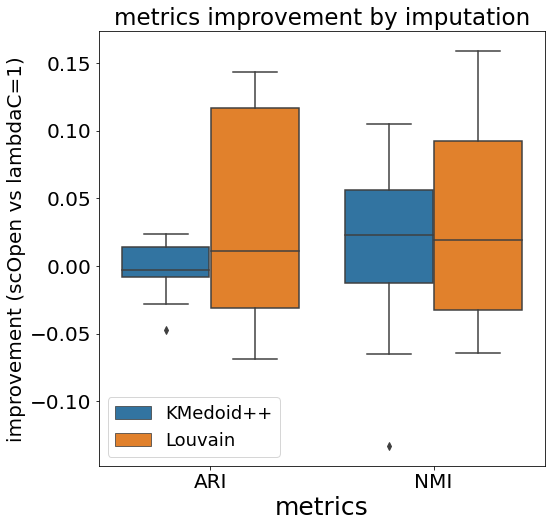

In [144]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='metrics', y='value', data=fugafuga, hue='method', ax=ax) # , palette='Dark2'

ax.set_xlabel('metrics', fontsize=25)
ax.set_ylabel('improvement (scOpen vs lambdaC=1)', fontsize=20)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("metrics improvement by imputation", fontsize=23)
# plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()

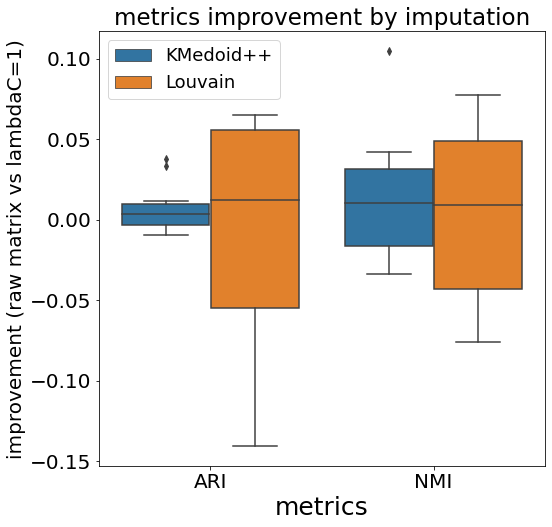

In [126]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='metrics', y='value', data=fugafuga, hue='method', ax=ax) # , palette='Dark2'

ax.set_xlabel('metrics', fontsize=25)
ax.set_ylabel('improvement (raw matrix vs lambdaC=1)', fontsize=20)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("metrics improvement by imputation", fontsize=23)
# plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()

In [95]:
# print(kARI_WHimputed, kARI_raw)
# print(kNMI_WHimputed, kNMI_raw)
# print(lARI_WHimputed, lARI_raw)
# print(lNMI_WHimputed, lNMI_raw)


0.034440102051237945 0.030144072120070812
0.10674883970428792 0.12546307626104236
0.3492233275951559 0.26522293632370186
0.5832585442270158 0.5055662955282014


,r,lambdaC,n_comp,n_cluster,n_nns,kARI_WH,kARI_X,kARI_diff,kNMI_WH,kNMI_X,kNMI_diff,lARI_WH,lARI_X,lARI_diff,lNMI_WH,lNMI_X,lNMI_diff
0,8.0,1.0,50.0,8.0,50.0,0.022683,0.027553,-0.00487,0.112992,0.09148,0.021512,0.288,0.232865,0.055135,0.461255,0.436175,0.02508


## Similarity Matrix

In [5]:
count_lsi = pd.read_csv("/home/naoto/scOpen/simATAC/Results/{}/v1.0/count_sim_bin_lsi_noise_{}_{}_{}.tsv".format(name, noise_mean, noise_sd, num), sep="\t")

FileNotFoundError: [Errno 2] No such file or directory: '/home/naoto/scOpen/simATAC/Results/Buenrostro2018/v1.0/count_sim_bin_lsi_noise_-1_1_1.tsv'

In [6]:
embedding = umap.UMAP().fit_transform(count_lsi.iloc[:,1:10])
plt.scatter(embedding[:,0],embedding[:,1],c=label_cat,cmap=cm.tab10, s=1)

NameError: name 'count_lsi' is not defined

In [7]:
count_lsi = pd.read_csv("/home/naoto/scOpen/simATAC/Results/{}/v1.0/count_sim_bin_lsi.tsv".format(name), sep="\t")

In [8]:
S_lsi_M = sklearn.metrics.pairwise.cosine_similarity(count_lsi.iloc[:, 1:10]) 

## NHMF

In [12]:
def CMF_Impute(X, S_c, r, lambda1, lambda2, lambdaC, positive=False):
    # input
    # X: peak-by-cell raw matrix (m, n)
    # S_c: cell-cell similarity matirx (n,n)
    
    # variable
    # W: (m,r)
    # H: (n,r)
    # I: eye(r)
    #r = int(n / _n)
    #X = X[:,:] * (1 / (1 - 0.9))
    #X = X * (1 / (1 - drop_rates_real))
#     X = scaling(X)

#     W, H = nndsvd_init(X,r)
    m = X.shape[0]
    n = X.shape[1]
    W = np.random.rand(m,r)
    H = np.random.rand(n,r)
    I = np.eye(r)
    
    # paremeters
    err = 1e-5
    max_iter = 300
    errors = []
    
    for _i in range(max_iter):
#         if _i % 100 == 0:
#             print(_i)

        W = (X @ H) @ np.linalg.inv(H.T @ H + lambda1 * I)
        if positive:
            W[W < 0] = 0
        H = (X.T @ W + lambdaC * S_c @ H) @ np.linalg.inv(W.T @ W + lambda2 * I + lambdaC * H.T @ H)
        if positive:
            H[H < 0] = 0

#         error = np.mean(np.mean(np.abs(A - H @ W.T))) / np.mean(np.mean(A))
        error = np.linalg.norm(X - W @ H.T, "fro")
        # + lambda1 * np.linalg.norm(W, "fro") + lambda2 * np.linalg.norm(H, "fro") + lambdaC * np.linalg.norm(S_c - H.T @ H, "fro")
        errors.append(error)
        
        if error < err:
            break
    return W @ H.T, W, H, errors
#     WH =  W @ H.T
#     WH_pos = np.where(WH < 0, 0, WH)
#     print("Imputing...")
#     AA = X.astype(float)
#     for i in range(m):
#         if i % 100 == 0:
#             print(i)
#         for j in range(n):
#             if X[i,j] == 0:
#                 AA[i,j] = WH_pos[i,j]
#     return AA, W, H, errors

In [25]:
m = X.shape[0]
n = X.shape[1]

rmse_x = mean_squared_error(M_bin, X, squared=False)
mae_x = mean_absolute_error(M_bin, X)

fpr_x, tpr_x, thresholds_x = roc_curve(M_bin.flatten(), X.flatten())
roc_auc_x = auc(fpr_x, tpr_x)

precision_x, recall_x, thresholds_pr_x = precision_recall_curve(M_bin.flatten(), X.flatten())
auprc_x= auc(recall_x, precision_x)

record =  pd.Series([name, m, n, noise_mean, noise_var, "X", 0, 1, 1, 0, rmse_x, mae_x, roc_auc_x, auprc_x], index=results.columns)
results = results.append(record, ignore_index=True)

rs = [5]#,8,10,20,30,40,50,100]
lambdaCs = [0]#, 0.1, 1]

for r in rs:
    for lambdaC in lambdaCs:
        WH, W, H, errors = CMF_Impute(X, S_lsi_M, r, 1,1,lambdaC, False)
        WH[WH < 0] = 0

        AA = X.astype(float)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if X[i,j] == 0:
                    AA[i,j] = WH[i,j]

        rmse_aa = mean_squared_error(M_bin, AA, squared=False)
        mae_aa = mean_absolute_error(M_bin, AA)
        print(rmse_aa, mae_aa)

        fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
        roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
        print(roc_auc_nhmf_aa)


        precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
        auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
        print(auprc_nhmf_aa)

        record =  pd.Series([name, m, n, noise_mean, noise_sd, num, "S_lsi_M", r, 1, 1, lambdaC, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
        results = results.append(record, ignore_index=True)
        
pd.DataFrame(X).to_csv("hoge.tsv", sep="\t")
for r in rs:

    !scopen --input hoge.tsv --input-format dense --output-dir ./ --output-prefix hoge_scOpen --output-format dense --n-components {r}          
    WH = pd.read_csv("hoge_scOpen.txt", sep="\t", index_col=0).to_numpy()
    print(WH.shape)

    WH[WH < 0] = 0

    AA = X.astype(float)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j] == 0:
                AA[i,j] = WH[i,j]

    rmse_aa = mean_squared_error(M_bin, AA, squared=False)
    mae_aa = mean_absolute_error(M_bin, AA)
    print(rmse_aa, mae_aa)

    fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
    roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
    print(roc_auc_nhmf_aa)


    precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
    auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
    print(auprc_nhmf_aa)

    record =  pd.Series([name, m, n, noise_mean, noise_sd, num, "scOpen", r, 1, 1, 0, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
    results = results.append(record, ignore_index=True)

0.37168734967311495 0.238423302469453
0.8555890850213947
0.8182315758846324


ValueError: Length of passed values is 15, index implies 14.

In [13]:
results

,name,m,n,noise_mean,noise_var,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,Buenrostro2018,5000,1974,-1,1,S_lsi_M,5,1,1,0,0.515143,0.369932,0.714513,0.608055


In [1]:
results.to_csv("simulation2_20210201_results_name{}_m{}_n{}_mean{}_var{}.tsv".format(name, m, n, mean, var), sep="\t")

NameError: name 'results' is not defined

In [ ]:
WH, W, H, errors = CMF_Impute(X, S_lsi_M, r, 1,1,lambdaC, False)

In [34]:
WH_S, W_S, H_S, errors_S = CMF_Impute(X, S_lsi_dot, 30, 1,1,1)

0
100
200


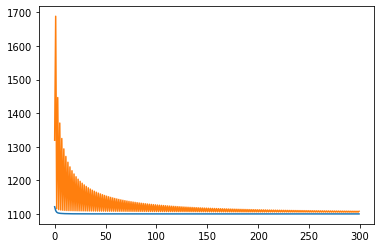

In [35]:
plt.plot(errors)
plt.plot(errors_S)

<AxesSubplot:>

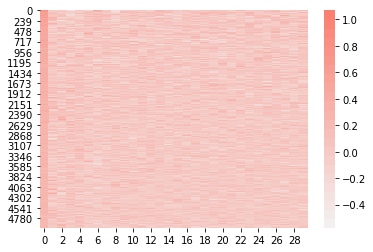

In [176]:
sns.heatmap(W, cmap=sns.light_palette("salmon", 24))

<AxesSubplot:>

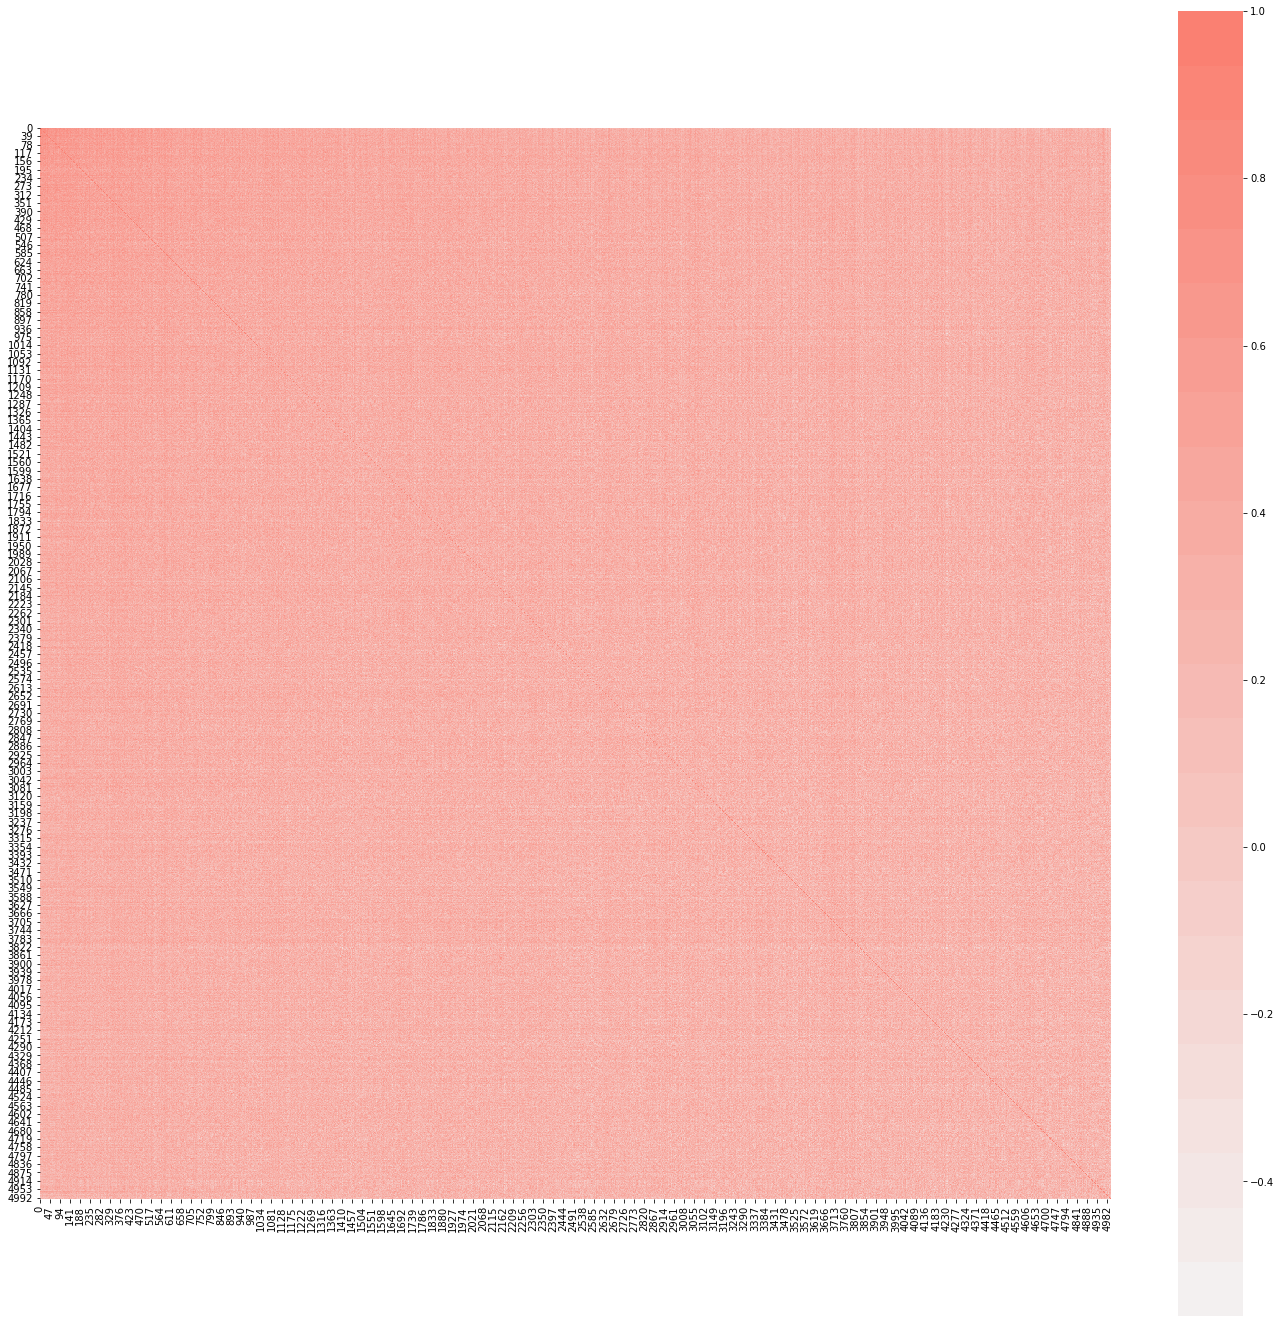

In [177]:
plt.figure(figsize=(24, 24))
S_w = sklearn.metrics.pairwise.cosine_similarity(W)
sns.heatmap(S_w, cmap=sns.light_palette("salmon", 24), square=True)

<AxesSubplot:>

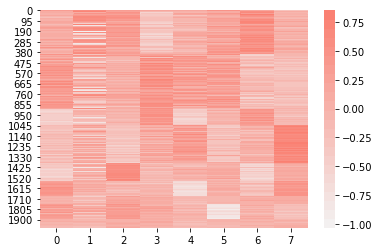

In [145]:
sns.heatmap(H, cmap=sns.light_palette("salmon", 24))

<AxesSubplot:>

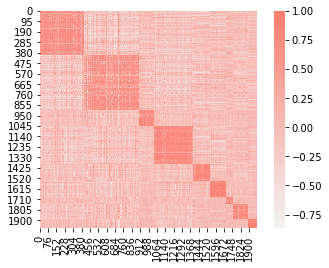

In [153]:
S_h = sklearn.metrics.pairwise.cosine_similarity(H)
sns.heatmap(S_h, cmap=sns.light_palette("salmon", 24), square=True)

In [154]:
H_S = pd.read_csv("hoge_scOpen_barcodes.txt", sep="\t", index_col=0).to_numpy()
H_S.shape

(30, 1974)

<AxesSubplot:>

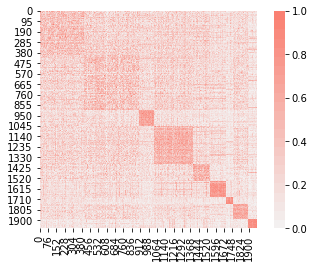

In [155]:
S_hs = sklearn.metrics.pairwise.cosine_similarity(H_S.T)
sns.heatmap(S_hs, cmap=sns.light_palette("salmon", 24), square=True)

<AxesSubplot:>

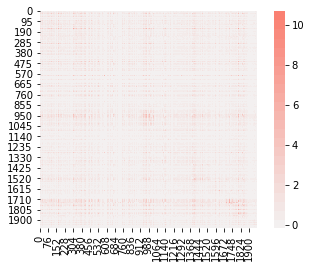

In [40]:
sns.heatmap(H @ H.T, cmap=sns.light_palette("salmon", 24), square=True)

<AxesSubplot:>

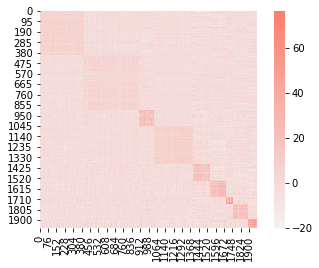

In [39]:
sns.heatmap(H_S @ H_S.T, cmap=sns.light_palette("salmon", 24), square=True)

<AxesSubplot:>

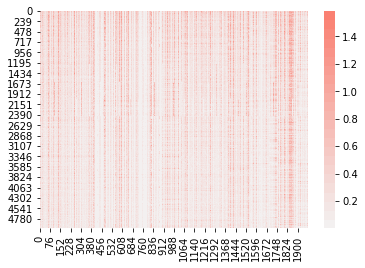

In [223]:
sns.heatmap(WH, cmap=sns.light_palette("salmon", 24))

<AxesSubplot:>

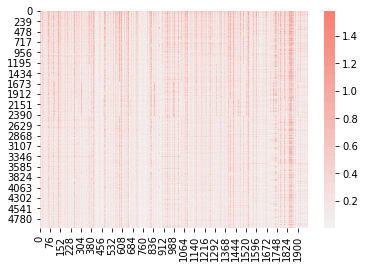

In [224]:
sns.heatmap(WH_S, cmap=sns.light_palette("salmon", 24))

In [41]:
rmse = mean_squared_error(M_bin, WH, squared=False)
mae = mean_absolute_error(M_bin, WH)
print(rmse, mae)

0.48699153070668594 0.3701291379566314


In [42]:
rmse = mean_squared_error(M_bin, WH_S, squared=False)
mae = mean_absolute_error(M_bin, WH_S)
print(rmse, mae)

0.4901295732301453 0.3730859987209558


In [43]:
m=5000
n=1974 #12178
rr_nhmf = np.sum((M_bin - X) * WH) / np.sum(M_bin - X)
fr_nhmf = (np.sum(WH) - np.sum(M_bin * WH)) / (m * n - np.sum(M_bin))
print(rr_nhmf)
print(fr_nhmf)

0.19492479596354126
0.1363433207772035


In [44]:
rr_nhmf = np.sum((M_bin - X) * WH_S) / np.sum(M_bin - X)
fr_nhmf = (np.sum(WH_S) - np.sum(M_bin * WH_S)) / (m * n - np.sum(M_bin))
print(rr_nhmf)
print(fr_nhmf)

0.19187296759396055
0.1338662204180068


In [45]:
fpr_x, tpr_x, thresholds_x = roc_curve(M_bin.flatten(), X.flatten())
roc_auc_x = auc(fpr_x, tpr_x)

In [46]:
precision_x, recall_x, thresholds_pr_x = precision_recall_curve(M_bin.flatten(), X.flatten())
auprc_x= auc(recall_x, precision_x)
print(auprc_x)

0.5582764120672006


In [47]:
fpr_nhmf, tpr_nhmf, thresholds_nhmf = roc_curve(M_bin.flatten(), WH.flatten())
roc_auc_nhmf = auc(fpr_nhmf, tpr_nhmf)
print(roc_auc_nhmf)

0.724505073014982


In [48]:
fpr_nhmf_S, tpr_nhmf_S, thresholds_nhmf_S = roc_curve(M_bin.flatten(), WH_S.flatten())
roc_auc_nhmf_S = auc(fpr_nhmf_S, tpr_nhmf_S)
print(roc_auc_nhmf_S)

0.710055624205769


In [49]:
precision_nhmf, recall_nhmf, thresholds_pr_nhmf = precision_recall_curve(M_bin.flatten(), WH.flatten())
auprc_nhmf= auc(recall_nhmf, precision_nhmf)
print(auprc_nhmf)

0.6354181624554736


In [50]:
precision_nhmf_S, recall_nhmf_S, thresholds_pr_nhmf_S = precision_recall_curve(M_bin.flatten(), WH_S.flatten())
auprc_nhmf_S= auc(recall_nhmf_S, precision_nhmf_S)
print(auprc_nhmf_S)

0.624501463166524


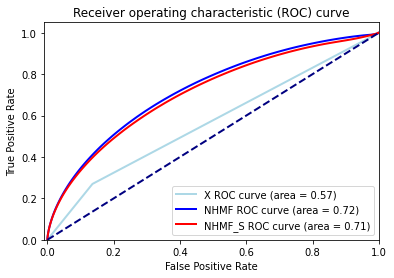

In [51]:
lw = 2
plt.plot(fpr_x, tpr_x, color='lightblue', lw=lw, label='X ROC curve (area = %0.2f)' % roc_auc_x)
#plt.plot(fpr_knn, tpr_knn, color='blue', lw=lw, label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
#plt.plot(fpr_ci, tpr_ci, color='red', lw=lw, label='CI ROC curve (area = %0.2f)' % roc_auc_ci)
plt.plot(fpr_nhmf, tpr_nhmf, color='blue', lw=lw, label='NHMF ROC curve (area = %0.2f)' % roc_auc_nhmf)
plt.plot(fpr_nhmf_S, tpr_nhmf_S, color='red', lw=lw, label='NHMF_S ROC curve (area = %0.2f)' % roc_auc_nhmf_S)

#plt.plot(fpr_so, tpr_so, color='purple', lw=lw, label='scOpen raw ROC curve (area = %0.2f)' % roc_auc_so)
#plt.plot(fpr_aa, tpr_aa, color='darkorange', lw=lw, label='scOpen filling ROC curve (area = %0.2f)' % roc_auc_aa)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

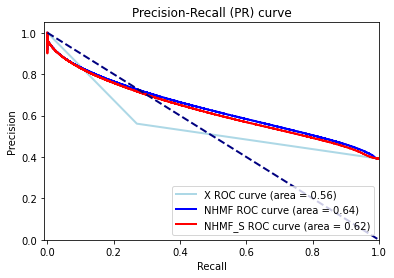

In [52]:
lw = 2
plt.plot(recall_x, precision_x, color='lightblue', lw=lw, label='X ROC curve (area = %0.2f)' % auprc_x)
#plt.plot(fpr_knn, tpr_knn, color='blue', lw=lw, label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
#plt.plot(fpr_ci, tpr_ci, color='red', lw=lw, label='CI ROC curve (area = %0.2f)' % roc_auc_ci)
plt.plot(recall_nhmf, precision_nhmf, color='blue', lw=lw, label='NHMF ROC curve (area = %0.2f)' % auprc_nhmf)
plt.plot(recall_nhmf_S, precision_nhmf_S, color='red', lw=lw, label='NHMF_S ROC curve (area = %0.2f)' % auprc_nhmf_S)

#plt.plot(fpr_so, tpr_so, color='purple', lw=lw, label='scOpen raw ROC curve (area = %0.2f)' % roc_auc_so)
#plt.plot(fpr_aa, tpr_aa, color='darkorange', lw=lw, label='scOpen filling ROC curve (area = %0.2f)' % roc_auc_aa)
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) curve')
plt.legend(loc="lower right")
plt.show()

In [158]:
AA = X.astype(float)
for i in range(m):
    if i % 100 == 0:
        print(i)
    for j in range(n):
        if X[i,j] == 0 and WH_S[i,j] > 0:
            AA[i,j] = WH_S[i,j]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [154]:
fpr_nhmf, tpr_nhmf, thresholds_nhmf = roc_curve(M_bin.flatten(), AA.flatten())
roc_auc_nhmf = auc(fpr_nhmf, tpr_nhmf)
print(roc_auc_nhmf)

0.8457389147049472


In [159]:
precision_nhmf, recall_nhmf, thresholds_pr_nhmf = precision_recall_curve(M_bin.flatten(), AA.flatten())
auprc_nhmf= auc(recall_nhmf, precision_nhmf)
print(auprc_nhmf)

0.8062386025274253


In [ ]:
embedding = umap.UMAP().fit_transform(count_lsi.iloc[:,1:10])
plt.scatter(embedding[:,0],embedding[:,1],c=label_cat,cmap=cm.tab10, s=1)